In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from os import path
import os
import pandas as pd
from statsmodels.tsa.stattools import adfuller


In [2]:
features = [
    "m_speed_stddev_480",
    "m_acceleration_stddev_480",
    "m_jerk_stddev_480",
    "m_steering_stddev_480",
    "AccelInput_stddev_480",
    "BrakeInput_stddev_480",
    "realtime steering entropy_1100",
    "realtime steering entropy_1100_stddev_480",
    "perclos",
]
TRAIN_DIR = 'dms_data/train/'
TEST_DIR = 'dms_data/test/'

train_csv = '20201126_1546_0_y_train.csv'
test_csv = train_csv.replace('train', 'test')

In [3]:
def solveOne(train_csv_path,test_csv_path,features,target,file_name=''):
  # train_df = pd.read_csv(path.join(TRAIN_DIR, train_csv))
  # test_df = pd.read_csv(path.join(TEST_DIR, test_csv))
  train_df = pd.read_csv(train_csv_path)
  test_df = pd.read_csv(test_csv_path)
  train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
  test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
  train_df.set_index('timestamp', inplace=True)
  test_df.set_index('timestamp', inplace=True)
  feature_scaler = MinMaxScaler()
  target_scaler = MinMaxScaler()
  train_df[features] = feature_scaler.fit_transform(train_df[features])
  test_df[features] = feature_scaler.transform(test_df[features])
  train_df[target] = target_scaler.fit_transform(train_df[[target]])
  test_df[target] = target_scaler.transform(test_df[[target]])
  model = ARIMA(train_df[target], order=(5,1,0))
  model_fit = model.fit()
  predictions = model_fit.forecast(steps=len(test_df))
  rmse = np.sqrt(mean_squared_error(test_df[target], predictions))
  print('Test RMSE: %.3f' % rmse)
  plt.title(f'{target} over Time')
  plt.xlabel('Timestamp')
  plt.ylabel(target)
  plt.plot(test_df.index, test_df[target], label='Actual')
  plt.plot(test_df.index, predictions, label='Predicted', color='red')
  plt.legend()
  if file_name != '':
    plt.savefig(path.join('./figure', file_name))
    # 画像を表示
    plt.show()
  return rmse

20201126_1546_0_arima-Sleepiness.png
Test RMSE: 0.308


/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

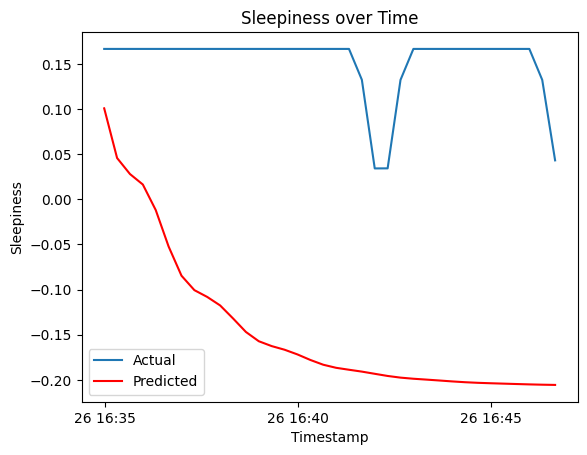

------------------------
20201127_1432_7_arima-Sleepiness.png
Test RMSE: 0.000


/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

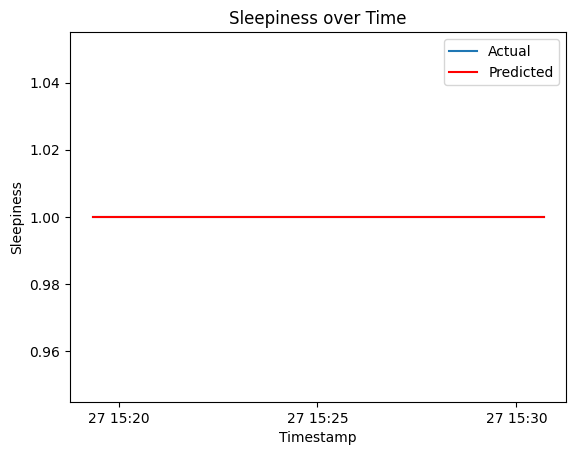

------------------------
20201127_1548_2_arima-Sleepiness.png
Test RMSE: 0.125


/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

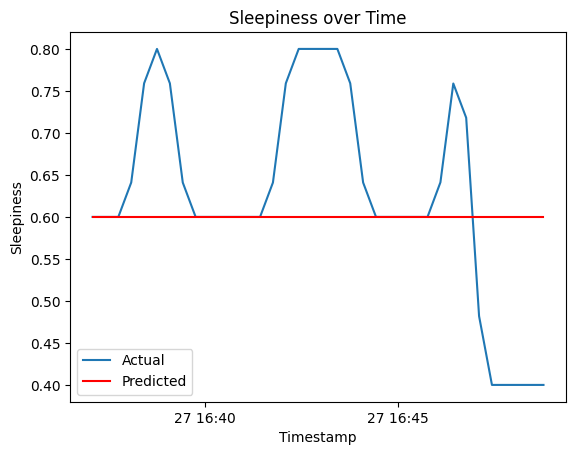

------------------------
20201127_1701_7_arima-Sleepiness.png
Test RMSE: 0.000


/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

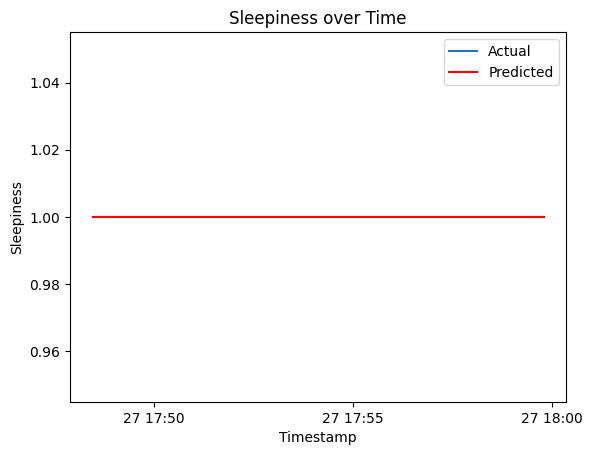

------------------------
20201127_1840_5_arima-Sleepiness.png
Test RMSE: 0.233


/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

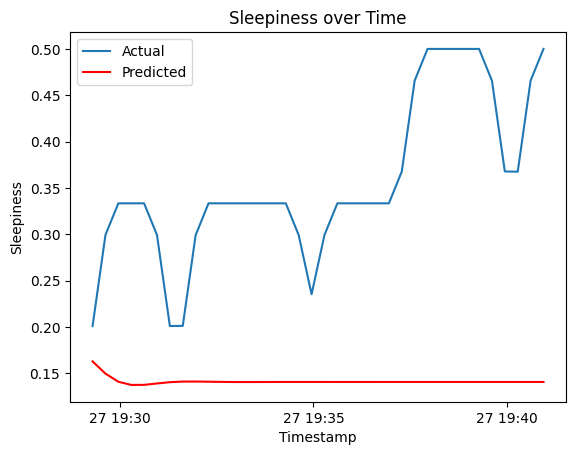

------------------------
20201130_1122_5_arima-Sleepiness.png
Test RMSE: 0.261


/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

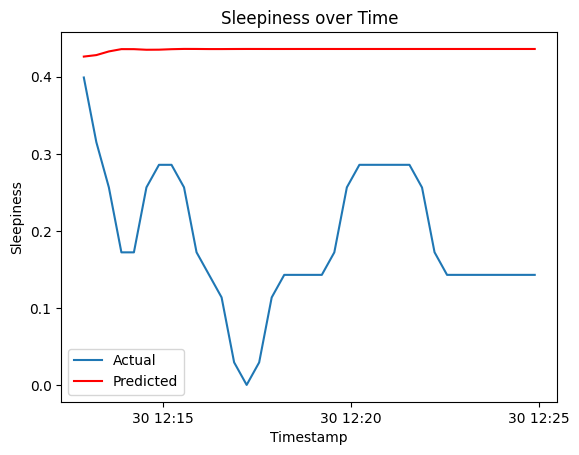

------------------------
20201130_1808_6_arima-Sleepiness.png
Test RMSE: 0.385


/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

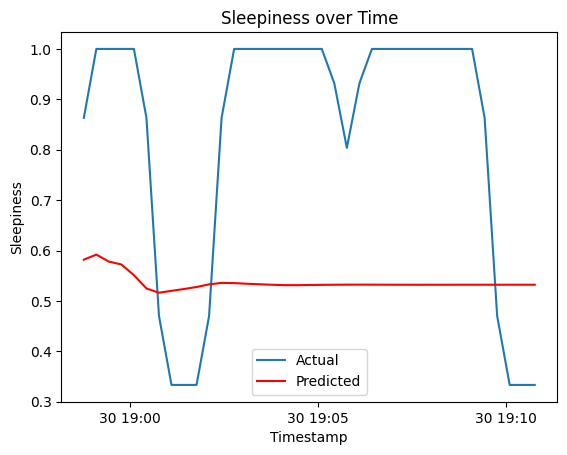

------------------------
20201201_1230_0_arima-Sleepiness.png
Test RMSE: 0.637


/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

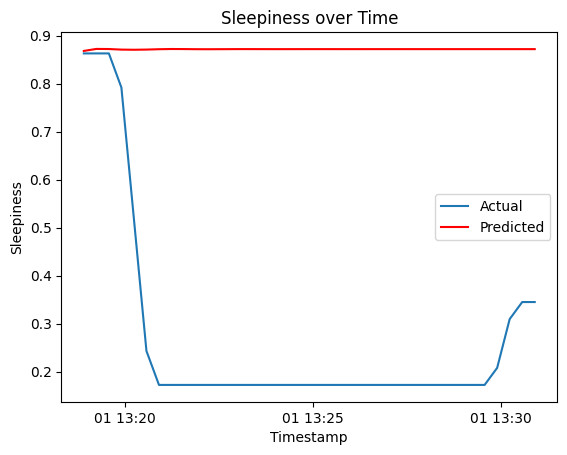

------------------------
20201201_1429_5_arima-Sleepiness.png
Test RMSE: 0.235


/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

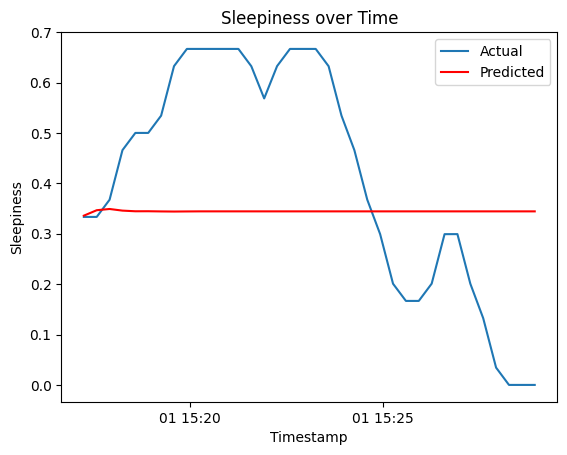

------------------------
20201201_1555_0_arima-Sleepiness.png
Test RMSE: 0.511


/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

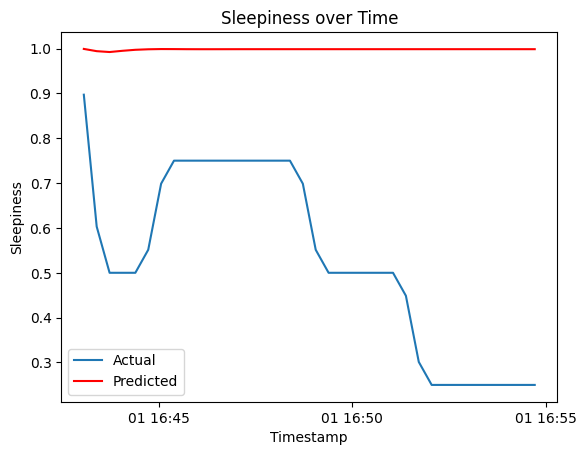

------------------------
20201203_1022_7_arima-Sleepiness.png
Test RMSE: 0.132


/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

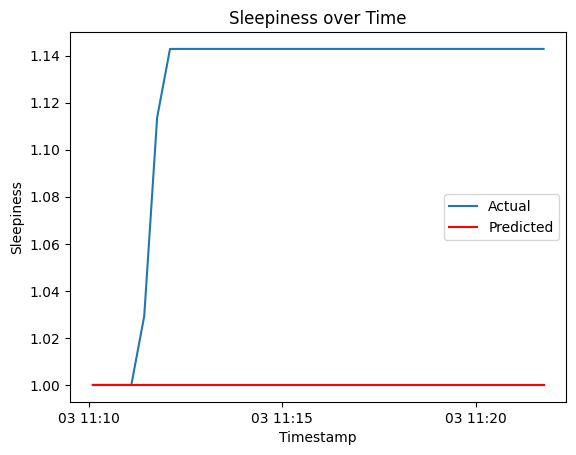

------------------------
20201203_1244_5_arima-Sleepiness.png
Test RMSE: 0.136


/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

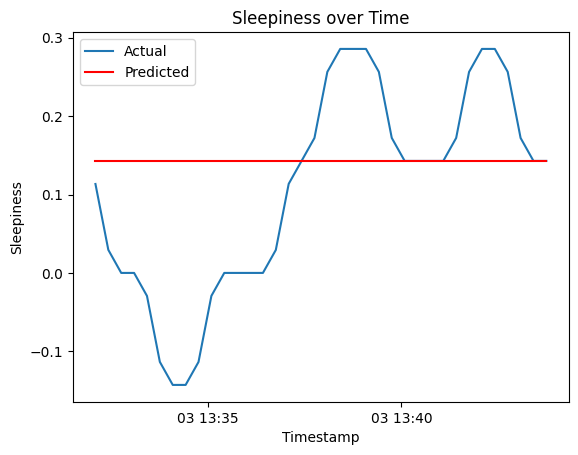

------------------------
20201203_1404_6_arima-Sleepiness.png
Test RMSE: 0.502


/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

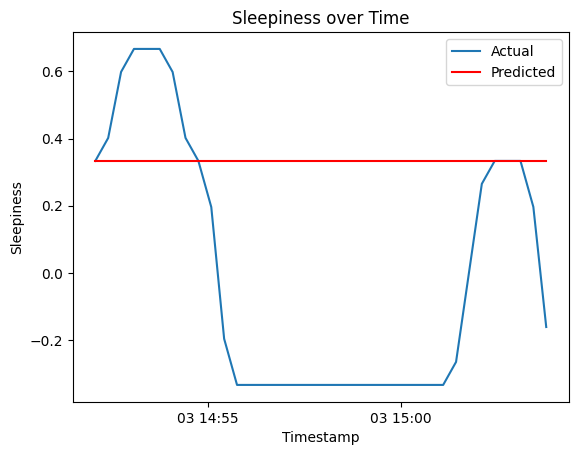

------------------------
20201210_1112_2_arima-Sleepiness.png
Test RMSE: 0.006


/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

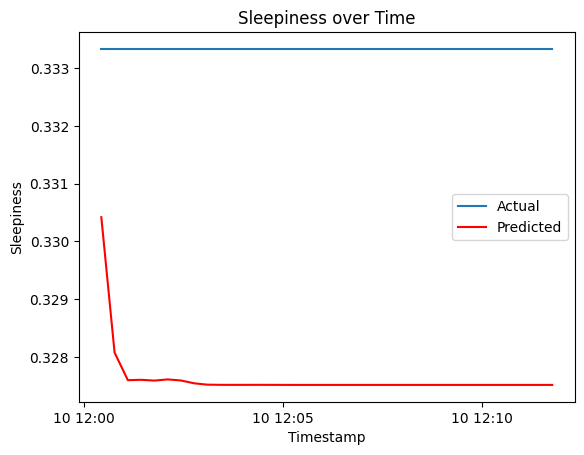

------------------------
20201210_1354_2_arima-Sleepiness.png
Test RMSE: 0.000


/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

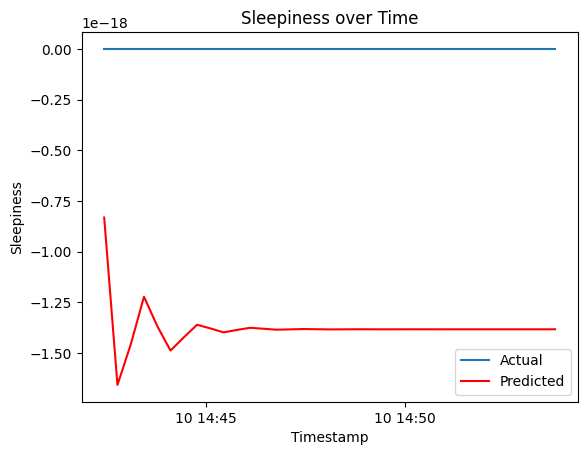

------------------------
20201210_1610_6_arima-Sleepiness.png
Test RMSE: 0.101


/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/buntin/jupyter-env/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

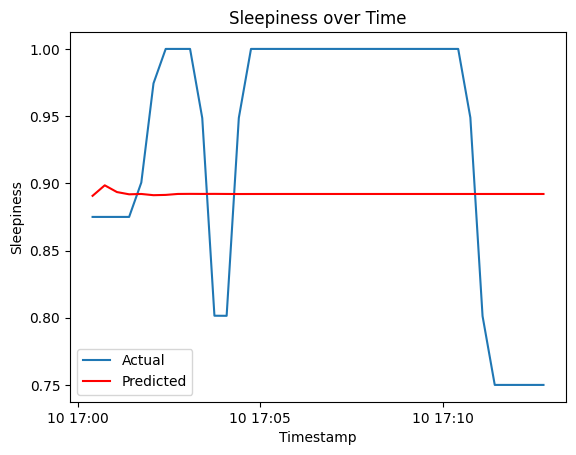

------------------------


In [4]:

""" 
target => 予測対象のカラム
"""
# target = 'oss'
target = 'Sleepiness'

csvs = os.listdir(TRAIN_DIR)
for csv in csvs:
  if csv.endswith('y_train.csv'):
    train_path = path.join(TRAIN_DIR, csv)
    test_path = path.join(TEST_DIR, csv.replace('train', 'test'))
    # test_path = train_path
    png_file_name = csv.replace('y_train.csv', f'arima-{target}.png')
    print(png_file_name.replace('y_train.csv', ''))
    solveOne(train_path,test_path,features,target,png_file_name)
    print('------------------------')